In [1]:
import sys
base_path = '/Users/yuri/git/diasYuri/tcc/radiation-forecast-mg'
sys.path.insert(0, base_path)

In [2]:
from pandas import DataFrame
from pydmd import HODMD
from src.dataframe import read_data_from_csv

import pandas as pd

import matplotlib.pyplot as plt

In [4]:
class DmdFiller:
    def __init__(self, d_factor=0.9):
        self.d_factor=d_factor

    def __reconstruct_data(self, values, steps):
        length = len(values)
        #print(values.T.shape)
        for v in values:
            if pd.isna(v):
                print(values.T)

        hodmd = HODMD(
                    svd_rank=0,
                    tlsq_rank=0,
                    exact=True,
                    opt=True,
                    forward_backward=True,
                    sorted_eigs='abs',
                    rescale_mode='auto',
                    reconstruction_method="mean",
                    d=int(length*self.d_factor)) \
            .fit(values.T)

        hodmd.original_time['tend'] = hodmd.dmd_time['tend'] = length-1
        hodmd.dmd_time['tend'] = length+steps-1

        return hodmd.reconstructed_data.T.real[length:]
    
    def __filler(self, values, empty_gaps):
        data_filled = values

        for i in range(len(empty_gaps)):
            (idx_lower, idx_top) = empty_gaps[i]

            if i > 0:
                (_, last_idx) = empty_gaps[i - 1]
            else:
                last_idx = 0

            steps = idx_top - idx_lower
            data_input = values[last_idx:idx_lower]

            if len(data_input) < 3 or steps > 15:
                data_input = data_filled[0:idx_lower-1]

            for v in data_input:
                if pd.isna(v):
                    print('dados restaurados:', data_input)

            data = self.__reconstruct_data(data_input, steps)

            #print('dados faltantes:', data_filled[idx_lower:idx_top+1])
            #print('dados restaurados:', data)
            #print(idx_lower, idx_top)
            for j in range(idx_lower, idx_top):
                data_filled[j] = data[j - idx_lower]


        return data_filled           
                    

    def look_for_empty_gaps(self, values):
        empty_spaces = []
        init = None

        for i, value in enumerate(values):
            if pd.isna(value):
                if init is None:
                    init = i
            else:
                if init is not None:
                    empty_spaces.append((init, i))
                    init = None

        if init is not None:
            empty_spaces.append((init, len(values) - 1))

        return empty_spaces
    
    def check_gap(self, idx, dict, list):
        for e in list:
            if idx >= e:
                if idx <= dict[e]:
                    return True    
            else:
                break
        return False

    
    def check(self, values, empty_gaps):
        dict = {}

        for e in empty_gaps:
            (init, end) = e
            dict[init] = end

        list = [i for (i, _) in empty_gaps]
        list.sort()

        for i, value in enumerate(values):
            if pd.isna(value):
                checked = self.check_gap(i, dict=dict, list=list)
                if checked is False:
                    print('Deu ruim:', i)



    def dmd_filler(self,
            serie: pd.Series,
            debug: bool = False) -> pd.Series:
        data = serie.copy()
        values = data.values.reshape(-1,1)
        index = data.index.values

        print(values.shape)

        empty_gaps = self.look_for_empty_gaps(values)
        #print(empty_gaps)
        self.check(data, empty_gaps)

        data_filled = self.__filler(values, empty_gaps)

        return pd.Series(data_filled.ravel(),
                        index=index,
                        name=data.name)
    

In [5]:
df = read_data_from_csv(f'{base_path}/data/daily_vicosa.csv')

In [7]:
df_complete = DmdFiller(d_factor=0.92).dmd_filler(df.RADIATION)

(6317, 1)


/Users/yuri/sdk/miniforge3/envs/tf/lib/python3.9/site-packages/pydmd/hodmd.py:140: UserWarning: The parameter 'svd_rank_extra=0' has been ignored because the given system is a scalar function
  warnings.warn(
/Users/yuri/sdk/miniforge3/envs/tf/lib/python3.9/site-packages/pydmd/utils.py:35: RuntimeWarning: SVD optimal rank is 0. The largest singular values are indistinguishable from noise. Setting rank truncation to 1.
  warnings.warn(


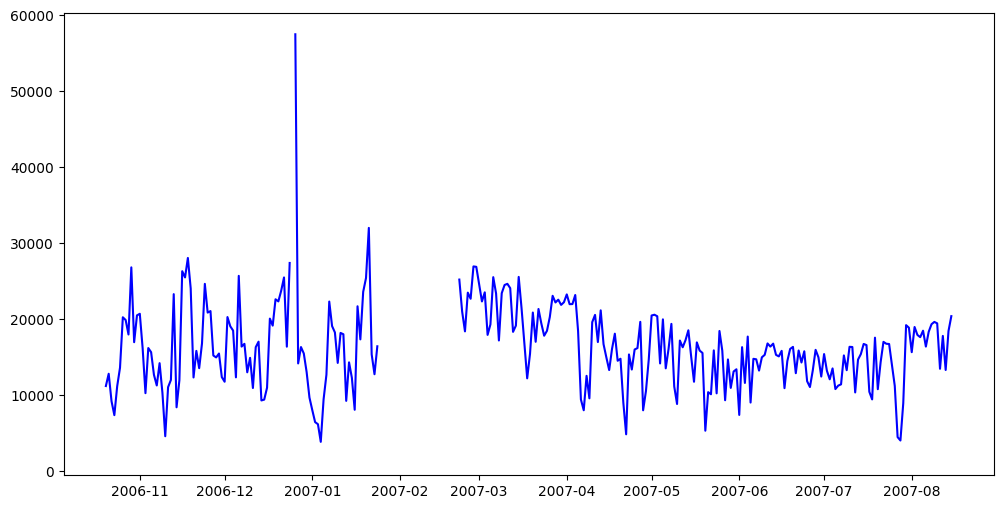

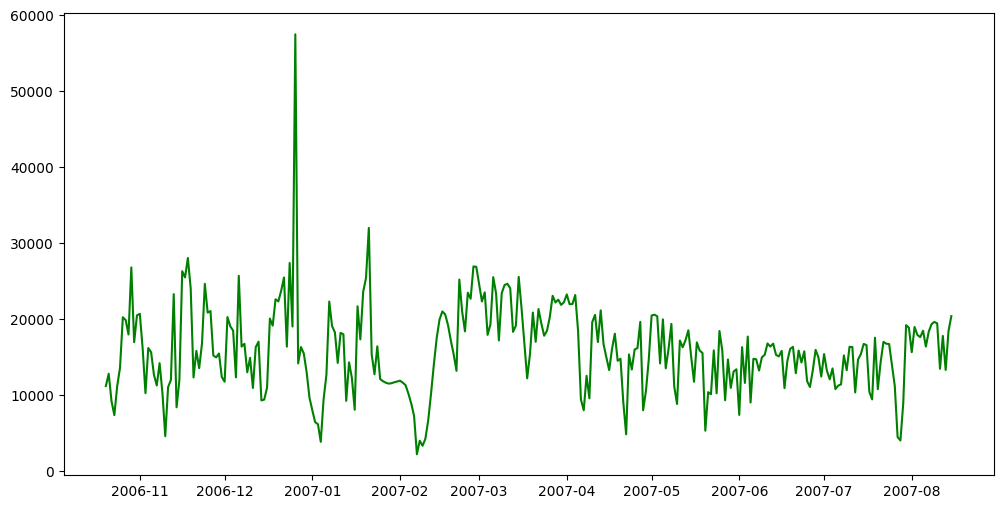

In [8]:
minrange = 400
maxrange = 300
plt.figure(figsize=(12, 6))
plt.plot(df['RADIATION'][minrange:minrange+maxrange], color='blue')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df_complete[minrange:minrange+maxrange], color='green')
plt.show()